In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *

In [ ]:
! {sys.executable} -m pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [ ]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
! mkdir %userprofile%\.kaggle
! move kaggle.json %userprofile%\.kaggle

/bin/bash: move: command not found


You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [ ]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [ ]:
! mv train-jpg.tar.7z {path}
! mv train_v2.csv.zip {path}

mv: cannot stat 'train-jpg.tar.7z': No such file or directory
mv: cannot stat 'train_v2.csv.zip': No such file or directory


In [ ]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [ ]:
! sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [ ]:
! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

/bin/bash: conda: command not found


And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [ ]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

In [ ]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)#flip vert will basically flip images in 8 possible ways because from the sky u all the directions of viewing is possible. check 30th minute for detailed explanation. 
#warp-basically if i look at you from above or below ur shape changes so when u are taling photo of cat or a dog, sometimes u will be higher or sometimes u will be lower so that kind of change in shape is definitely something u want to include as u are creating ur trianing batches. but satellite u are only seeing from above therefore we keep the warping off. this is called data augmentation.
#flip_vert= true generally helps ur model to generalise better.

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [ ]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

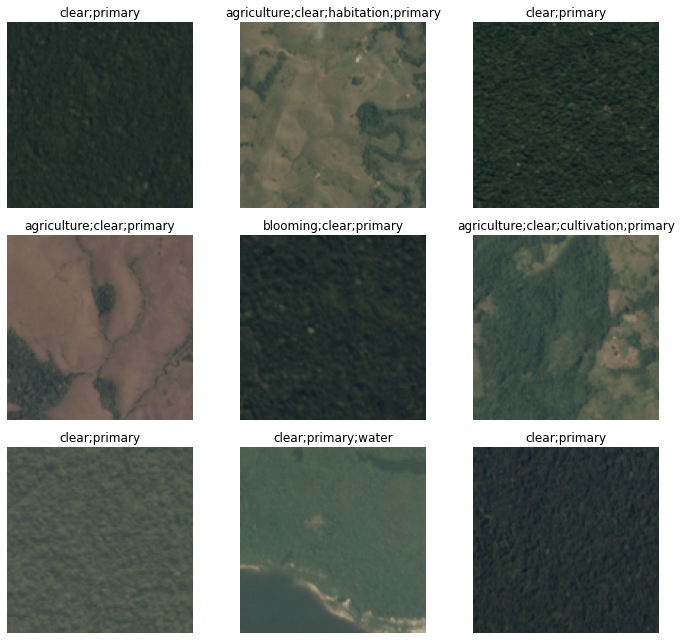

In [ ]:
data.show_batch(rows=3, figsize=(10,9))

In [ ]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [ ]:
data.c

17

In [ ]:
arch = models.resnet50

In [ ]:
accuracy??

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])#metric has got nothing to do with how the model trains. changing ur metrics will not change ur resulting model at all.the only thing we use metrics is fo, to print them out during training.

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


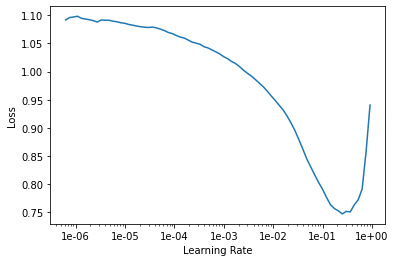

In [ ]:
learn.recorder.plot()

Then we can fit the head of our network.

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137304,0.115914,0.944330,0.900972,02:24
1,0.112725,0.098875,0.951313,0.912750,02:22
2,0.104890,0.093401,0.951473,0.916413,02:22
3,0.094353,0.088480,0.956945,0.922895,02:21
4,0.091535,0.087184,0.955863,0.923555,02:22


In [ ]:
learn.save('stage-1-rn50')

NameError: ignored

...And fine-tune the whole model:

In [ ]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


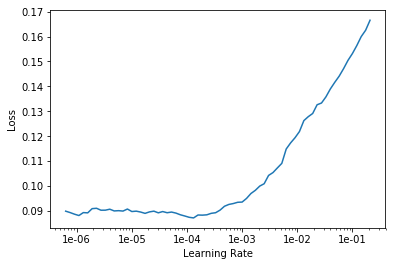

In [ ]:
learn.lr_find()
learn.recorder.plot()# to chose learning rate just go 10x behind.

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5)) #u can check out the from 42nd minute of the video. he clears a doubt regarding collecting misclassified images and training them with a higher learning rate. this is called fine tuning.

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098635,0.091461,0.951008,0.919683,02:29
1,0.098447,0.089835,0.956029,0.921770,02:31
2,0.090880,0.086854,0.957345,0.924435,02:32
3,0.086135,0.083446,0.957272,0.928773,02:34
4,0.081818,0.082676,0.959278,0.929322,02:38


In [ ]:
learn.save('stage-2-rn50')

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data#we are replacing the data inside the leaner with the new data bunch and then we will freeze again. that means we are just going back to train the last few layers.
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


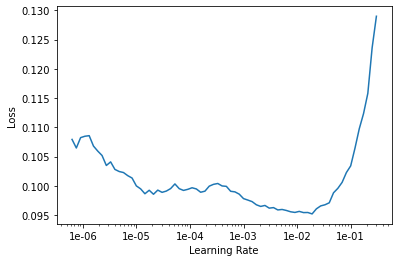

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.089373,0.085761,0.957185,0.925059,05:02
1,0.088381,0.087575,0.958762,0.920432,05:03
2,0.086400,0.082587,0.957425,0.929112,05:06
3,0.081517,0.081671,0.960636,0.930241,05:16
4,0.081586,0.081222,0.959663,0.930954,05:07


In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.083960,0.083232,0.954714,0.925974,05:15
1,0.086406,0.084247,0.957330,0.929546,05:15
2,0.082217,0.081970,0.958144,0.928735,05:19
3,0.078687,0.081444,0.959569,0.931021,05:21
4,0.074665,0.080686,0.959721,0.930877,05:23


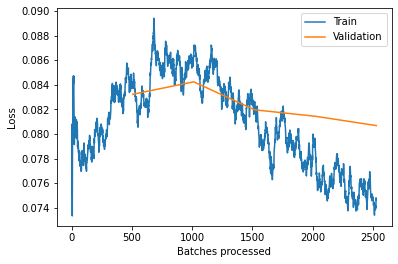

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

In [ ]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [ ]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

['agriculture cultivation partly_cloudy primary road',
 'clear haze primary water',
 'agriculture clear cultivation primary',
 'clear primary',
 'partly_cloudy primary']

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

In [ ]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100%|██████████████████████████████████████| 2.18M/2.18M [00:02<00:00, 1.05MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9296 (around 80th)